## Image segmentation with polyDataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision.all import *
from fastai.data.all import *
from fastai.torch_basics import *
import os
from pathlib import Path
import torch
import numpy as np
import pandas as pd
from monai.losses import DiceLoss

### Setting the path of polypData that we are going to segment

In [3]:
path = Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG') 
path.ls()
#print(path)

(#16) [Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/testmaskimages_cmix'),Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/.ipynb_checkpoints'),Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/kavsir_bboxes.json'),Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/.DS_Store'),Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/testimages'),Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/codes.txt'),Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks'),Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/images'),Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks1SSize'),Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/models')...]

In [4]:
path_img = path/'images'
path_lbl = path/'bmasks1'
# path_img = path/'imagesSSize'
# path_lbl = path/'bmasks1SSize'

### Data (images/masks) listing

In [5]:
fnames = sorted(get_image_files(path_img))
fnames[:3]

[Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/images/cju0qkwl35piu0993l0dewei2.jpg'),
 Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/images/cju0qoxqj9q6s0835b43399p4.jpg'),
 Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/images/cju0qx73cjw570799j4n5cjze.jpg')]

In [6]:
lbl_names = sorted(get_image_files(path_lbl))
lbl_names[:3]

[Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks1/cju0qkwl35piu0993l0dewei2_b.png'),
 Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks1/cju0qoxqj9q6s0835b43399p4_b.png'),
 Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks1/cju0qx73cjw570799j4n5cjze_b.png')]

In [7]:
###Binarize All data
# for i, imfile enumerate(fnames):
#     mask = open_mask(get_y_fn(imfile))
#     #mask.show(figsize=(5,5), alpha=1, cmap='gray')
#     bmask=createbinarymask(Imdata, threshold)

In [8]:
# def createbinarymask(Imdata, threshold):

# #     # Create fake images
# #     data = torch.Tensor(14, 10).random_(0, 255)
# #     print(data)

#     # # Apply threshold
#     Imdata = Imdata > threshold
#     Imdata = Imdata.float()
# #     print('Threshold')
# #     print(data)

#     # # Create real masks for every image
#     print('Mask')
# #     mask = torch.Tensor(14, 10).random_(0, 2)
#     Imdata = Imdata * 255
#     return Imdata

In [9]:
####Counting uniques numbers from a mask or from the tensor data
#print(torch.unique(mask.data,return_counts=True))
#torch.unique(torch.tensor([1, 3, 2, 3], dtype=torch.long))
#bmaskdata=createbinarymask(mask.data,threshold=50)
#torch.unique(bmaskdata)
#print(torch.unique(bmaskdata), bmaskdata.shape)

In [10]:
####The binarization without a funtion 
# Imdata=mask.data
# Imdata = Imdata > 50
# Imdata = Imdata.float()
# print(Imdata)
# print(torch.unique(Imdata), Imdata.shape)
# Imdata = Imdata * 255
# print(torch.unique(Imdata), Imdata.shape)

In [11]:
codes = np.array(['Background','Polypblob']); codes

array(['Background', 'Polypblob'], dtype='<U10')

## Datasets, creating a dataloader for segmenataion using fastai2

In [12]:
! nvidia-smi

Sun Nov 22 22:21:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 450.66       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:09:00.0 Off |                  N/A |
| 41%   33C    P8    15W / 280W |    862MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:42:00.0 Off |                  N/A |
| 40%   

(<AxesSubplot:>, <AxesSubplot:>)

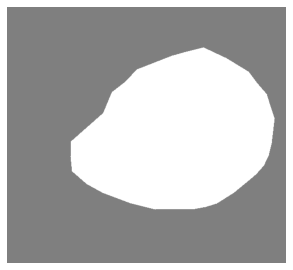

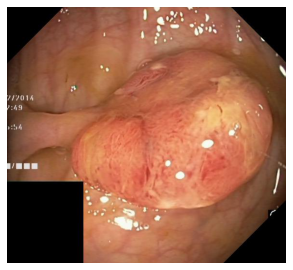

In [13]:
fnames = get_image_files(path/'images')
poly_fn = fnames[0]
mask_fn = path/'bmasks1'/f'{poly_fn.stem}_b.png'

poly_img = PILImage.create(poly_fn)
#test_eq(poly_img.size, (128,96))
tmask = Transform(PILMask.create)
mask = tmask(mask_fn)
test_eq(type(mask), PILMask)
#test_eq(mask.size, (128,96))
mask.show(cmap='gray'), poly_img.show()

In [14]:
### Fastai2 dataloader
fnames = get_image_files(path/'images')
#def label_func(x): return path/'labels'/f'{x.stem}_b{x.suffix}'
label_func = lambda o: path/'bmasks1'/f'{o.stem}_b.png'
codes = np.array(['Background','Polypblob']);  ###method=ResizeMethod.Squish  item_tfms=Resize(128)
item_tfms  = [Resize(256, method=ResizeMethod.Squish)]  #### method='crop'
batch_tfms = [*aug_transforms(size=256), Normalize.from_stats(*imagenet_stats)]
dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func, valid_pct=0.2, codes=codes, item_tfms=item_tfms, batch_tfms=batch_tfms, bs=16)

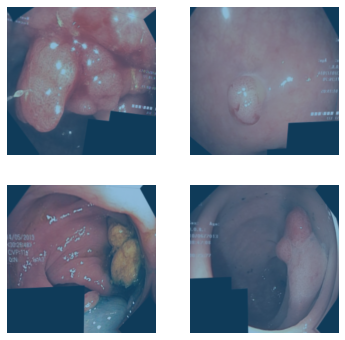

In [15]:
dls.show_batch(max_n=4)

### looking inside the dataloader 

In [16]:
#n_out = get_c(dls)
dls.one_batch()[0].shape, dls.one_batch()[0].unique(), dls.one_batch()[0].dtype, dls.one_batch()[0].min(), dls.one_batch()[0].max(), dls.one_batch()[1].shape, dls.one_batch()[1].unique(), dls.one_batch()[1].dtype

(torch.Size([16, 3, 256, 256]),
 TensorImage([-2.1179, -2.1179, -2.1179,  ...,  2.6400,  2.6400,  2.6400],
        device='cuda:0'),
 torch.float32,
 TensorImage(-2.1179, device='cuda:0'),
 TensorImage(2.6400, device='cuda:0'),
 torch.Size([16, 256, 256]),
 TensorMask([0, 1], device='cuda:0'),
 torch.int64)

In [17]:
dls.one_batch()

(TensorImage([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1031, -2.1170, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1070, -2.1066, -2.1162],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1091, -2.1105, -2.1170],
           ...,
           [-2.1179, -2.1179, -2.1179,  ...,  0.4789,  0.6057,  0.6716],
           [-2.1179, -2.1179, -2.1179,  ...,  0.5877,  0.6706,  0.7382],
           [-2.1179, -2.1179, -2.1179,  ...,  0.6587,  0.7276,  0.7995]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0334, -2.0288, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0310, -2.0349, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0337, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -1.0028, -0.9616, -0.9080],
           [-2.0357, -2.0357, -2.0357,  ..., -0.9412, -0.9237, -0.8866],
           [-2.0357, -2.0357, -2.0357,  ..., -0.9406, -0.9095, -0.8689]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8009, -1.8039, -1.8044],
        

### Custom loss function

F.binary_cross_entropy_with_logits requires both y_pred and y_true in same shape, and same data type. So F.one_hot and permute functions are used here. The Diceloss function requires channel dimension, so y_true tensor in unsqueezed.

In [18]:
device=torch.device('cuda:0')
class DiceCELogitLoss(Module):
    def __init__(self):
        super().__init__()
        self.dice = DiceLoss(to_onehot_y=True, softmax=True)
        #self.cross_entropy = nn.CrossEntropyLoss()
        #self.cross_entropyLogit = nn.BCEWithLogitsLoss()

    def forward(self, y_pred, y_true):
        y_true1 = F.one_hot(y_true)
        y_true1 = y_true1.permute(0,3,1,2).float()
        
        y_true2 = y_true.unsqueeze(dim=1)
        
        ulabels, ucounts = torch.unique(y_true, sorted=True, return_counts = True)
        posweight = torch.true_divide(ucounts[0], ucounts[1])
        posweight = torch.Tensor([posweight]).to(device)
        
        #breakpoint()
        cross_entropy=F.binary_cross_entropy_with_logits(y_pred, y_true1, pos_weight = posweight)   #### 
        
        dice = self.dice(y_pred, y_true2)
        #cross_entropy = self.cross_entropy(y_pred, y_true)
        return dice + cross_entropy
    
    def activation(self, out): return F.softmax(out, dim=1)
    def decodes(self, out):    return out.argmax(dim=1)

In [19]:
class DiceCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice = DiceLoss(to_onehot_y=True, softmax=True)
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, y_pred, y_true):
        dice = self.dice(y_pred, y_true.unsqueeze(dim = 1))
        cross_entropy = self.cross_entropy(y_pred, y_true)
        return dice + cross_entropy
    
    def activation(self, out): return F.softmax(out, dim=1)
    def decodes(self, out):    return out.argmax(dim=1)

In [20]:
import sys
sys.path.insert(0,'/home/saruarlive/MyProjects/customlosses/')

In [21]:
from losscollections import NoiseRobustDiceLoss as NoiseRobustDiceLoss
#NRdicelossInstance = NoiseRobustDiceLoss(gamma = 1.5, Enable_Pixel_Weight = True, Enable_Class_Weight=False)

In [22]:
class NRDiceLoss(Module):
    def __init__(self):
        super().__init__()
        #self.dice = DiceLoss(to_onehot_y=True, softmax=True)
        self.NoiseRobustDiceLoss = NoiseRobustDiceLoss(gamma = 1.5, Enable_Pixel_Weight = False, Enable_Class_Weight=True, to_onehot_y=True)


    def forward(self, y_pred, y_true):

        ulabels, ucounts = torch.unique(y_true, sorted=True, return_counts = True)
        
#         #####  If to calculate pixel weights this is code block
#         pixweight = torch.empty_like(y_pred)
    
#         posweight = torch.ones(len(ucounts),1)
#         for i in range(len(ucounts)):
#             posweight[i,:] = torch.true_divide(ucounts[0], ucounts[i])
            
#         posweight /= posweight.max(0, keepdim=True)[0] 
      
        
#         for i in range(len(ucounts)):
#             pixweight[:, i, :, :] = torch.where(y_true == ulabels[i],posweight[i,0].expand_as(y_true).to(device),torch.Tensor([0]).expand_as(y_true).to(device))
            
        
        ######If to calculate class weights here
       
        wucounts = torch.true_divide(ucounts.sum(), len(ucounts)*ucounts) ##### formula of balanced weights scikit learn types
        #wucounts /= wucounts.max(0, keepdim=True)[0] 
     
     
        #dice = self.NoiseRobustDiceLoss(y_pred, y_true.unsqueeze(dim=1), pix_w = pixweight, softmax=False)
        dice = self.NoiseRobustDiceLoss(y_pred, y_true.unsqueeze(dim=1), cls_w = wucounts, softmax=True)
       
        #cross_entropy = self.cross_entropy(y_pred, y_true)
        return dice 
    
    def activation(self, out): return F.softmax(out, dim=1)
    def decodes(self, out):    return out.argmax(dim=1)

### Training a model from fastai2

In [23]:
#metrics=[acc,Dice(axis=1)]
#metrics=acc
#nn.BCEWithLogitsLoss?

#DiceLoss
#to_fp16??

In [24]:
learn = unet_learner(dls, resnet34, loss_func=NRDiceLoss(), metrics=Dice(axis=1), cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=15)])##.to_fp16()
#learn = unet_learner(dls, models.resnet34, loss_func=CrossEntropyLossFlat(axis=1))
learn.freeze()

#### learning rate finder

(0.00036307806149125097, 6.309573450380412e-07)

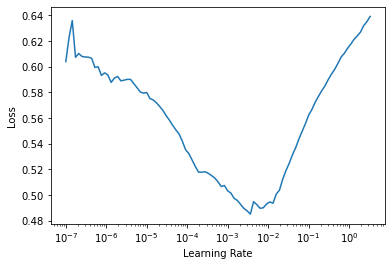

In [25]:
lr_min,lr_steep = learn.lr_find()
lr_min,lr_steep

In [26]:
learn.fine_tune(80, freeze_epochs=20)

epoch,train_loss,valid_loss,dice,time
0,0.275784,0.199383,0.742210,00:14
1,0.209698,0.182014,0.760404,00:14
2,0.183186,0.166885,0.784723,00:14
3,0.165682,0.162742,0.791786,00:14
4,0.157266,0.166860,0.792360,00:14
5,0.152891,0.161427,0.797257,00:14
6,0.134913,0.156610,0.796654,00:14
7,0.142587,0.225768,0.726376,00:14
8,0.136923,0.142730,0.813228,00:14
9,0.133416,0.174885,0.784933,00:14


epoch,train_loss,valid_loss,dice,time
0,0.073211,0.124369,0.846029,00:15
1,0.069123,0.128320,0.840844,00:15
2,0.063258,0.125929,0.844388,00:15
3,0.060120,0.129620,0.839139,00:15
4,0.060496,0.120518,0.854138,00:15
5,0.057803,0.116964,0.854322,00:15
6,0.055233,0.113713,0.859535,00:15
7,0.051450,0.114604,0.858275,00:15
8,0.052714,0.126395,0.846256,00:15
9,0.050854,0.113537,0.859099,00:15


No improvement since epoch 53: early stopping


In [ ]:
lr = 1e-03
learn.fit_one_cycle(3, lr_max=lr)

##### Unfreezing learner

In [25]:
learn.unfreeze()

#### Discriminative Learning Rates

https://arxiv.org/abs/1411.1792

In [31]:
5e-3

0.005

In [ ]:
slr=slice(5e-5,5e-3)
learn.fit_one_cycle(20, lr_max=slr)

epoch,train_loss,valid_loss,dice,time
0,0.897862,0.884674,0.713880,00:41
1,0.731663,0.621182,0.740589,00:41
2,0.640886,0.675659,0.774152,00:41
3,1.906509,1.512885,0.000000,00:41
4,1.698950,1.362223,0.000001,00:41
5,1.964508,1.136252,0.507548,00:41
6,1.373344,1.196931,0.422248,00:41
7,1.182935,1.152104,0.504345,00:41
8,1.138905,1.122843,0.401592,00:41
9,1.096295,1.137611,0.461757,00:41


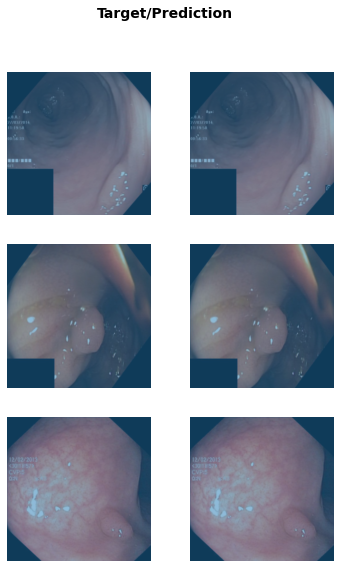

In [27]:
learn.show_results()

In [28]:
# findx=40
# PILImage.create(fnames[findx]).show()
# im0=learn.predict(fnames[findx])[2][1,:].unsqueeze(0)
# show_image(im0, cmap='gray')
# #im0.shape
# type(im0)

#### Displaying testimages and corresponding segmented regions

In [52]:
fnames = sorted(get_image_files(path/'images'))
masks = sorted(get_image_files(path/'bmasks1'))
imgdicts={}
flist=[80, 500, 10, 100]
for i, img in enumerate(flist):
    imgdicts[0,i]=PILImage.create(fnames[img])
    imgdicts[1,i]=PILMask.create(masks[img])
    imgdicts[2,i]=learn.predict(fnames[img])[2][1,:].unsqueeze(0)
    
show_images((imgdicts[0,0],imgdicts[0,1],imgdicts[0,2],imgdicts[0,3],imgdicts[1,0],imgdicts[1,1],imgdicts[1,2],imgdicts[1,3], imgdicts[2,0],imgdicts[2,1],imgdicts[2,2],imgdicts[2,3]),
            titles=('images','','','', 'masks', '','','','output', '','',''), nrows=3, ncols=4)

IndexError: too many indices for tensor of dimension 1

In [51]:
fnames = get_image_files(path/'testimages')
imgdicts={}
flist=[20, 40, 50, 60]
for i, img in enumerate(flist):
    imgdicts[0,i]=PILImage.create(fnames[img])
    imgdicts[1,i]=learn.predict(fnames[img])[2][1,:].unsqueeze(0)

IndexError: too many indices for tensor of dimension 1

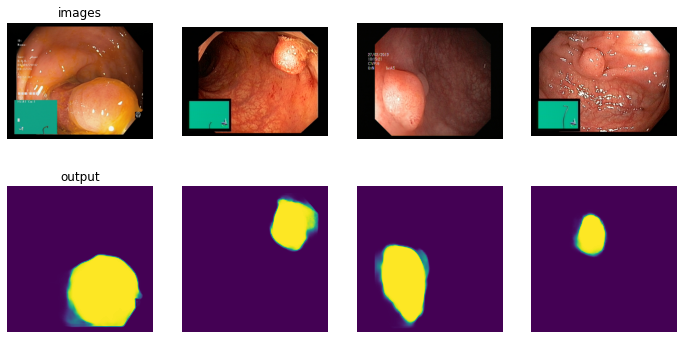

In [31]:
#show_images((PILImage.create(fnames[findx]),im0), titles=('number','puppy'), nrows=2, ncols=4, imsize=8, figsize=(8,8))
show_images((imgdicts[0,0],imgdicts[0,1],imgdicts[0,2],imgdicts[0,3],imgdicts[1,0],imgdicts[1,1],imgdicts[1,2],imgdicts[1,3]), titles=('images','','','', 'output', '','','',), nrows=2, ncols=4)

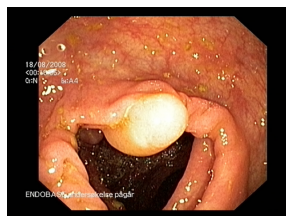

In [117]:
timages = get_image_files(path/'testimages')
maskdir=path/'testmaskimages'
PILImage.create(timages[49]).show()
xxp=learn.predict(timages[49])
xxp[1].shape
tensormask=xxp[1]  #### channel last so unsqueezed on 2
save_mask(timages[49], tensormask, maskdir)
#axnum=tensormask.numpy().astype('int16')*255
#axnum=np.uint8(tensormask.numpy())*255
#imgz=Image.fromarray(axnum)

In [25]:
timages = sorted(get_image_files(path/'testimages'))
maskdir=path/'testmaskimagesV2'

for i, fpath in enumerate(timages):
    tensormask=learn.predict(fpath)[0]
    save_mask(fpath, tensormask, maskdir)

In [24]:
def save_mask(filename, tensormask, spath):
    testsize=PILImage.create(filename).size  ###width, height
    imgg=Image.fromarray(tensormask.numpy().astype('uint8')*255)
    imgg=imgg.resize(testsize, resample=Image.NEAREST)
    spath1=spath/f'{filename.stem}_segoutput{filename.suffix}'   
    imgg.save(spath1)

### Using fastai2's cutmix method
https://arxiv.org/abs/1905.04899

In [21]:
#export
from torch.distributions.beta import Beta
class CutMix(Callback):
    "Implementation of `https://arxiv.org/abs/1905.04899`"
    run_after,run_valid = [Normalize],False
    def __init__(self, alpha=1.): self.distrib = Beta(tensor(alpha), tensor(alpha))
    def before_fit(self):
        self.stack_y = getattr(self.learn.loss_func, 'y_int', False)
        if self.stack_y: self.old_lf,self.learn.loss_func = self.learn.loss_func,self.lf

    def after_fit(self):
        if self.stack_y: self.learn.loss_func = self.old_lf

    def before_batch(self):
        W, H = self.xb[0].size(3), self.xb[0].size(2)
        lam = self.distrib.sample((1,)).squeeze().to(self.x.device)
        lam = torch.stack([lam, 1-lam])
        self.lam = lam.max()
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        xb1,self.yb1 = tuple(L(self.xb).itemgot(shuffle)),tuple(L(self.yb).itemgot(shuffle))
        nx_dims = len(self.x.size())
        x1, y1, x2, y2 = self.rand_bbox(W, H, self.lam)
        self.learn.xb[0][:, :, x1:x2, y1:y2] = xb1[0][:, :, x1:x2, y1:y2]
        self.lam = (1 - ((x2-x1)*(y2-y1))/float(W*H)).item()

        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

    def lf(self, pred, *yb):
        if not self.training: return self.old_lf(pred, *yb)
        with NoneReduce(self.old_lf) as lf:
            loss = torch.lerp(lf(pred,*self.yb1), lf(pred,*yb), self.lam)
        return reduce_loss(loss, getattr(self.old_lf, 'reduction', 'mean'))

    def rand_bbox(self, W, H, lam):
        cut_rat = torch.sqrt(1. - lam)
        cut_w = (W * cut_rat).type(torch.long)
        cut_h = (H * cut_rat).type(torch.long)
        # uniform
        cx = torch.randint(0, W, (1,)).to(self.x.device)
        cy = torch.randint(0, H, (1,)).to(self.x.device)
        x1 = torch.clamp(cx - cut_w // 2, 0, W)
        y1 = torch.clamp(cy - cut_h // 2, 0, H)
        x2 = torch.clamp(cx + cut_w // 2, 0, W)
        y2 = torch.clamp(cy + cut_h // 2, 0, H)
        return x1, y1, x2, y2

In [22]:
cutmix = CutMix(alpha=1.)

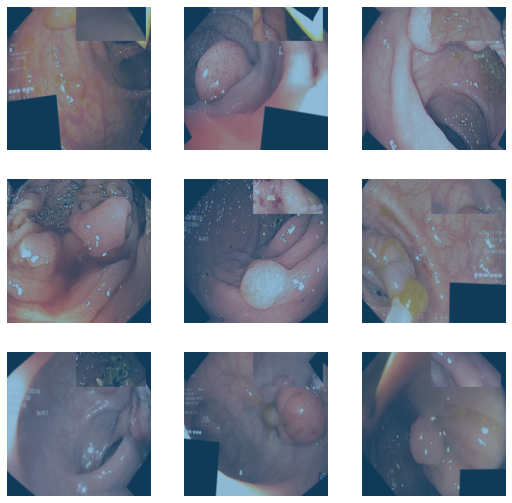

In [23]:
with Learner(dls, resnet34(), loss_func=CrossEntropyLossFlat(axis=1), cbs=cutmix) as learn:
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(cutmix.x,cutmix.y), ctxs=axs.flatten())

(1.9054606673307718e-05, 2.0892961401841603e-05)

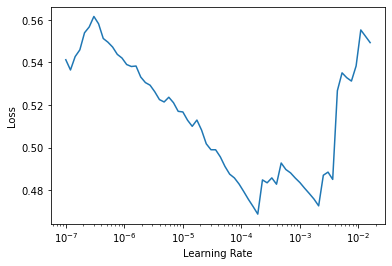

In [24]:
#cutmix = CutMix(alpha=1.)
learn = unet_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(axis=1), cbs=cutmix, metrics=Dice(axis=1))
lr_min,lr_steep = learn.lr_find()
lr_min,lr_steep

In [25]:
# lr=1e-04
# learnCM.fit_one_cycle(20, lr)
learn.fine_tune(5, freeze_epochs=3)

epoch,train_loss,valid_loss,dice,time
0,0.343625,0.230685,0.736984,00:16
1,0.347383,2.642597,0.000000,00:16
2,0.516708,0.429132,0.000000,00:16


epoch,train_loss,valid_loss,dice,time
0,0.336345,0.293624,0.331802,00:17
1,0.289495,0.211012,0.762638,00:17
2,0.265317,0.180194,0.810719,00:17
3,0.252811,0.175137,0.830297,00:17
4,0.229319,0.163057,0.833895,00:17


In [27]:
timages = sorted(get_image_files(path/'testimages'))
maskdir=path/'testmaskimages_cmix'

# for i, fpath in enumerate(timages):
#     tensormask=learn.predict(fpath)[0]
#     save_mask(fpath, tensormask, maskdir)

tt=learn.predict(timages[15])
#mtnsr=torch.add(tt[2][1,:,:], tt[0][0,:,:])
# tnsr=mtnsr.numpy().astype('int64')
# np.unique(tnsr)
#save_cmixmask(timages[10], tt[2][1,:,:], maskdir)
#np.sum(tnsr==5)
# tt[2][1,:,:].shape
# ttfill=torch.empty(256,256)
# for i in range(256):
#     for j in range(256):
#         if tt[2][1,i,j]>tt[2][0,i,j]:
#             ttfill[i,j]=1
#         elif tt[2][1,i,j]<=tt[2][0,i,j]:
#             ttfill[i,j]=1
#         else:
#             print('just do')   

In [31]:
tt=learn.predict(timages[15])
print(tt[0].shape, tt[1].shape, tt[2].shape)
tt

torch.Size([2, 256, 256]) torch.Size([2, 256, 256]) torch.Size([2, 256, 256])


(TensorMask([[[ 3.4512,  3.7648,  4.8309,  ...,  4.3966,  3.3230,  3.1817],
          [ 3.4074,  3.9261,  4.4212,  ...,  4.3434,  3.4921,  3.5464],
          [ 3.4284,  4.2890,  4.5556,  ...,  4.4926,  3.9719,  3.7626],
          ...,
          [ 3.2073,  3.9376,  4.0297,  ...,  4.3225,  3.9797,  3.4936],
          [ 3.1094,  3.7204,  4.0000,  ...,  3.9928,  3.5525,  3.0001],
          [ 2.3231,  3.0874,  3.3625,  ...,  3.4455,  3.0873,  2.4396]],
 
         [[-1.3106, -1.6256, -1.6847,  ..., -1.7499, -1.4720, -1.5663],
          [-1.5804, -1.7009, -1.7038,  ..., -1.8240, -1.5723, -1.8536],
          [-2.1167, -2.1542, -2.2181,  ..., -2.1904, -2.1333, -2.2366],
          ...,
          [-1.8759, -1.9530, -1.8910,  ..., -2.1399, -2.0717, -2.0120],
          [-1.7063, -1.8884, -1.9664,  ..., -1.9779, -1.8324, -1.6924],
          [-1.8951, -2.0246, -2.0611,  ..., -1.9492, -1.7637, -1.4994]]]),
 tensor([[[ 3.4512,  3.7648,  4.8309,  ...,  4.3966,  3.3230,  3.1817],
          [ 3.4074,  3.9

In [64]:
def save_cmixmask(filename, tensormask, spath):
    testsize=PILImage.create(filename).size  ###width, height
    imgg=Image.fromarray(tensormask.numpy().astype('uint8'))
    imgg=imgg.resize(testsize, resample=Image.NEAREST)
    spath1=spath/f'{filename.stem}_segoutput{filename.suffix}'   
    imgg.save(spath1)

RuntimeError: number of dims don't match in permute

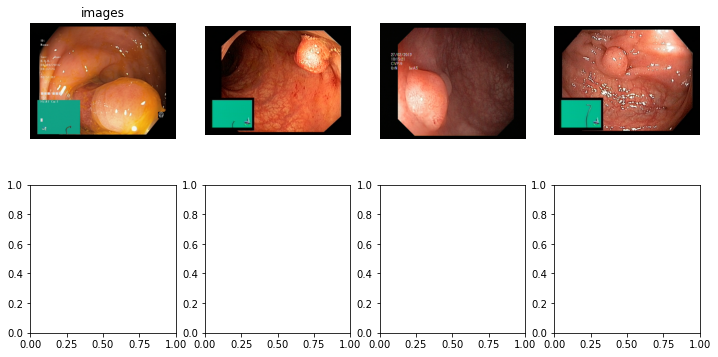

In [50]:
fnames = get_image_files(path/'testimages')
imgdicts={}
flist=[20, 40, 50, 60]
for i, img in enumerate(flist):
    imgdicts[0,i]=PILImage.create(fnames[img])
    imgdicts[1,i]=learnCM.predict(fnames[img])[1].unsqueeze(0) ###learnCM.predict(fnames[img])[2][1,:].unsqueeze(0)
show_images((imgdicts[0,0],imgdicts[0,1],imgdicts[0,2],imgdicts[0,3],imgdicts[1,0],imgdicts[1,1],imgdicts[1,2],imgdicts[1,3]), titles=('images','','','', 'output', '','','',), nrows=2, ncols=4)

In [49]:
learnCM.predict(fnames[20])

(TensorMask([[[ 3.9405,  4.1320,  5.0548,  ...,  5.2502,  4.8665,  4.5017],
          [ 4.1017,  4.2058,  4.7216,  ...,  4.9211,  4.5202,  4.4897],
          [ 4.2851,  4.5020,  4.8621,  ...,  5.0723,  4.8464,  4.8479],
          ...,
          [ 3.3307,  3.5963,  3.8713,  ...,  3.9128,  3.8855,  3.5057],
          [ 2.9114,  3.2500,  3.8035,  ...,  3.8669,  3.7030,  3.2755],
          [ 2.5655,  2.7842,  3.2996,  ...,  3.2826,  3.1910,  2.8812]],
 
         [[-1.9044, -1.7767, -1.4400,  ..., -1.4691, -0.7599, -1.0369],
          [-1.9826, -1.8217, -1.7985,  ..., -1.7917, -1.2660, -1.3095],
          [-2.3818, -2.2268, -2.0116,  ..., -2.1932, -1.9165, -1.8225],
          ...,
          [-1.8061, -1.7902, -1.7438,  ..., -1.7038, -1.8146, -1.7226],
          [-1.7277, -1.6739, -1.9481,  ..., -1.8912, -1.8623, -1.7385],
          [-1.6517, -1.8162, -1.9842,  ..., -1.9498, -1.8124, -1.6344]]]),
 tensor([[[ 3.9405,  4.1320,  5.0548,  ...,  5.2502,  4.8665,  4.5017],
          [ 4.1017,  4.2

In [54]:
learnCM.predict(fnames[20])[0].shape

torch.Size([2, 256, 256])

### Creating a dataloader using pandas DataFrame

In [18]:
fnames = sorted(get_image_files(path_img))
lnames = sorted(get_image_files(path_lbl))

def get_childpath(imglblpath):
    ##x=f'{fnames[0].parent.stem}/{fnames[0].stem}{fnames[0].suffix}'
    return f'{imglblpath.parent.stem}/{imglblpath.stem}{imglblpath.suffix}'

lstfnames=[]
lstlnames=[]
for i in range(len(fnames)):
    lstfnames.append(get_childpath(fnames[i]))
    lstlnames.append(get_childpath(lnames[i]))


In [19]:
#DataDict=[{'image': imagename, 'label': labelname} for imagename, labelname in zip(fnames, lnames)]
DataDict={'fnames': lstfnames, 'lnames':lnames}
df=pd.DataFrame(DataDict)
df.head()

,fnames,lnames
0,images/cju0qkwl35piu0993l0dewei2.jpg,/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks1/cju0qkwl35piu0993l0dewei2_b.png
1,images/cju0qoxqj9q6s0835b43399p4.jpg,/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks1/cju0qoxqj9q6s0835b43399p4_b.png
2,images/cju0qx73cjw570799j4n5cjze.jpg,/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks1/cju0qx73cjw570799j4n5cjze_b.png
3,images/cju0roawvklrq0799vmjorwfv.jpg,/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks1/cju0roawvklrq0799vmjorwfv_b.png
4,images/cju0rx1idathl0835detmsp84.jpg,/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks1/cju0rx1idathl0835detmsp84_b.png


In [20]:
# ### Can be done using pandas library
# from sklearn.model_selection import train_test_split
# train, test = train_test_split(df, test_size=0.2)
# len(train)

#### Using pandas only
is_valid=[]
dfTrain=df.sample(frac=0.8,random_state=200)

xx=~df.index.isin(dfTrain.index)
np.unique(xx, return_counts=True)
df['is_valid']=xx
df.head()

,fnames,lnames,is_valid
0,images/cju0qkwl35piu0993l0dewei2.jpg,/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks1/cju0qkwl35piu0993l0dewei2_b.png,True
1,images/cju0qoxqj9q6s0835b43399p4.jpg,/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks1/cju0qoxqj9q6s0835b43399p4_b.png,False
2,images/cju0qx73cjw570799j4n5cjze.jpg,/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks1/cju0qx73cjw570799j4n5cjze_b.png,True
3,images/cju0roawvklrq0799vmjorwfv.jpg,/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks1/cju0roawvklrq0799vmjorwfv_b.png,False
4,images/cju0rx1idathl0835detmsp84.jpg,/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks1/cju0rx1idathl0835detmsp84_b.png,False


In [21]:
print(path)

/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG


In [22]:
codes = np.array(['Background','Polypblob']); 
item_tfms  = [Resize(256, method=ResizeMethod.Squish)]  #### method='crop'
batch_tfms = [*aug_transforms(size=256), Normalize.from_stats(*imagenet_stats)]
dls = ImageDataLoaders.from_df(df, path=path, valid_col='is_valid', y_block=MaskBlock(codes=codes), bs=10, item_tfms=item_tfms, batch_tfms=batch_tfms)


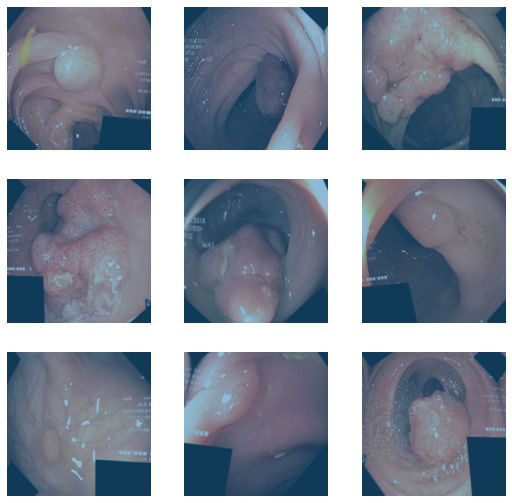

In [23]:
dls.show_batch()

(6.918309954926372e-05, 7.585775847473997e-07)

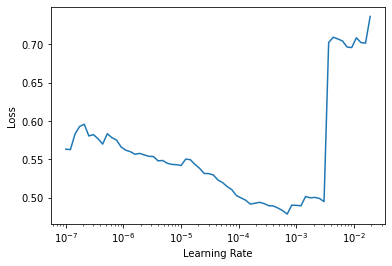

In [24]:
learn = unet_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=Dice(axis=1))
lr_min,lr_steep = learn.lr_find()
lr_min,lr_steep

In [ ]:
# lr = 1e-03
# learn.fit_one_cycle(20, lr)

learn.fine_tune(20, freeze_epochs=3)

epoch,train_loss,valid_loss,dice,time
0,0.302665,0.262968,0.461632,00:18
1,0.263114,0.187139,0.725449,00:18
2,0.224049,0.195824,0.736204,00:18


epoch,train_loss,valid_loss,dice,time
0,0.141552,0.150664,0.815809,00:19
1,0.122254,0.139888,0.823391,00:19
2,0.110013,0.127069,0.844498,00:19
3,0.104620,0.141132,0.842059,00:19
4,0.104849,0.167554,0.820668,00:19
5,0.086476,0.121063,0.858440,00:19
6,0.084175,0.155219,0.860690,00:19
7,0.075550,0.126289,0.865354,00:19
8,0.074819,0.138788,0.849166,00:19
9,0.064269,0.101434,0.878093,00:19


RuntimeError: number of dims don't match in permute

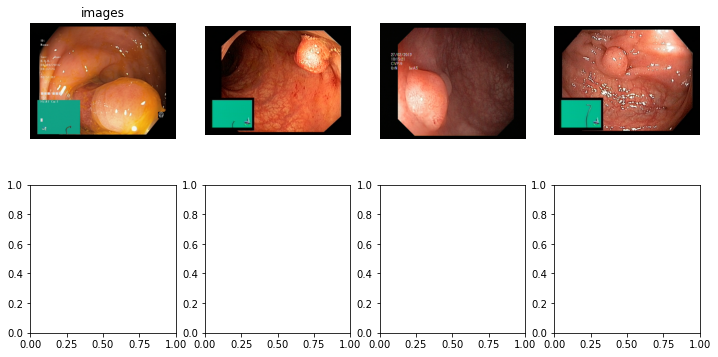

In [62]:
fnames = get_image_files(path/'testimages')
imgdicts={}
flist=[20, 40, 50, 60]
for i, img in enumerate(flist):
    imgdicts[0,i]=PILImage.create(fnames[img])
    imgdicts[1,i]=learn.predict(fnames[img])[1].unsqueeze(0)
show_images((imgdicts[0,0],imgdicts[0,1],imgdicts[0,2],imgdicts[0,3],imgdicts[1,0],imgdicts[1,1],imgdicts[1,2],imgdicts[1,3]), titles=('images','','','', 'output', '','','',), nrows=2, ncols=4)

### Creating custom data loader class

In [ ]:
class customSegImgDataLoaders(DataLoaders):
    
    
    @classmethod
    @delegates(DataLoaders.from_dblock)
    
    def from_folders(cls, path, trainfold='trainsss', label_mask='masksss', valid_pct=0.2, seed=None, codes=None, item_tfms=None, batch_tfms=None, **kwargs):        
        #get_y_fn1 = lambda x: path/label_mask/f'{x.stem}_b.png'
        #get_y_fn1 = lambda x: path/label_mask/f'{x.stem}.png'
        fnames = get_image_files(path/trainfold)
        #firstlabel_suffix=get_image_files(path/label_mask)[0].suffix
        def label_func(x): return path/label_mask/f'{x.stem}_b.png'
        splitter=RandomSplitter(valid_pct, seed=seed)
        y_block = MaskBlock(codes=codes)
        
        dblock = DataBlock(blocks=(ImageBlock, y_block),
                           splitter=splitter,
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        res = cls.from_dblock(dblock, fnames, path=path, **kwargs)
        return res
        
        
        
    @classmethod
    @delegates(DataLoaders.from_dblock)

    def from_dictionary_list(cls, listdicts, valid_pct=0.2, seed=None, item_tfms=None, codes=None, batch_tfms=None, **kwargs):

        imgkey=list(listdicts[0].keys())[0]
        lblkey=list(listdicts[0].keys())[1]

        def label_func(x): return listdicts[0][lblkey].parent/f'{x.stem}_b{listdicts[0][lblkey].suffix}'


        label_lists = []
        fnames = []
        for i, imagename in enumerate(listdicts):

            fnames.append(imagename[imgkey])
            #label_lists.append(imagename['label'])

        splitter=RandomSplitter(valid_pct, seed=seed)
        y_block = MaskBlock(codes=codes)

        dblock = DataBlock(blocks=(ImageBlock, y_block),
                           splitter=splitter,
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, fnames, path=path, **kwargs)
    
    
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_label_func2(cls, path, labelfold='labelsAll', fnamesfold='imagesall', valid_pct=0.2, seed=None, codes=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`."
        splitter=RandomSplitter(valid_pct, seed=seed)
        y_block = MaskBlock(codes=codes)
        fnames = get_image_files(path/fnamesfold)
        #label_func = lambda x: path/labelfold/f'{x.stem}_b.png'
        def label_func(x): return path/labelfold/f'{x.stem}_b.png'
        
        dblock = DataBlock(blocks=(ImageBlock, y_block),
                           splitter=splitter,
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        res = cls.from_dblock(dblock, fnames, path=path, **kwargs)
        return res
            
            
    
  #pass

### Creating another custom data loader class

In [59]:
class ImageDataLoadersEx(ImageDataLoaders):
    
    
    @classmethod
    @delegates(DataLoaders.from_dblock)
    
    def from_folders(cls, path, trainfold='trainsss', label_mask='masksss', valid_pct=0.2, seed=None, codes=None, item_tfms=None, batch_tfms=None, **kwargs):        
        #get_y_fn1 = lambda x: path/label_mask/f'{x.stem}_b.png'
        #get_y_fn1 = lambda x: path/label_mask/f'{x.stem}.png'
        fnames = get_image_files(path/trainfold)
        #firstlabel_suffix=get_image_files(path/label_mask)[0].suffix
        def label_func(x): return path/label_mask/f'{x.stem}_b.png'
        splitter=RandomSplitter(valid_pct, seed=seed)
        y_block = MaskBlock(codes=codes)
        
        dblock = DataBlock(blocks=(ImageBlock, y_block),
                           splitter=splitter,
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        res = cls.from_dblock(dblock, fnames, path=path, **kwargs)
        return res
        
        
        
    @classmethod
    @delegates(DataLoaders.from_dblock)

    def from_dictionary_list(cls, listdicts, valid_pct=0.2, seed=None, item_tfms=None, codes=None, batch_tfms=None, **kwargs):

        imgkey=list(listdicts[0].keys())[0]
        lblkey=list(listdicts[0].keys())[1]

        def label_func(x): return listdicts[0][lblkey].parent/f'{x.stem}_b{listdicts[0][lblkey].suffix}'


        label_lists = []
        fnames = []
        for i, imagename in enumerate(listdicts):

            fnames.append(imagename[imgkey])
            #label_lists.append(imagename['label'])

        splitter=RandomSplitter(valid_pct, seed=seed)
        y_block = MaskBlock(codes=codes)

        dblock = DataBlock(blocks=(ImageBlock, y_block),
                           splitter=splitter,
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, fnames, path=path, **kwargs)
    
    
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_label_func2(cls, path, labelfold='labelsAll', fnamesfold='imagesall', valid_pct=0.2, seed=None, codes=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`."
        splitter=RandomSplitter(valid_pct, seed=seed)
        y_block = MaskBlock(codes=codes)
        fnames = get_image_files(path/fnamesfold)
        #label_func = lambda x: path/labelfold/f'{x.stem}_b.png'
        def label_func(x): return path/labelfold/f'{x.stem}_b.png'
        
        dblock = DataBlock(blocks=(ImageBlock, y_block),
                           splitter=splitter,
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        res = cls.from_dblock(dblock, fnames, path=path, **kwargs)
        return res

In [60]:
### Fastai2 dataloader
fnames = get_image_files(path/'images')
get_y_fn = lambda x: path_lbl/f'{x.stem}_b.png'
#def label_func(x): return path/'labels'/f'{x.stem}_b{x.suffix}'
#codes = np.loadtxt(path/'codes.txt', dtype=str)
codes = np.array(['Background','Polypblob']);  ###method=ResizeMethod.Squish  item_tfms=Resize(128)
item_tfms  = [Resize(256, method=ResizeMethod.Squish)]  #### method='crop'
batch_tfms = [*aug_transforms(size=256), Normalize.from_stats(*imagenet_stats)]
dlsMy = ImageDataLoadersEx.from_label_func2(path, labelfold='bmasks1', fnamesfold='images', valid_pct=0.2, codes=codes, item_tfms=item_tfms, batch_tfms=batch_tfms, bs=10)
#dlsMy = customSegImgDataLoaders.from_folders(path, trainfold='images', label_mask='bmasks1', valid_pct=0.2, codes=codes, item_tfms=item_tfms, batch_tfms=batch_tfms, bs=10)

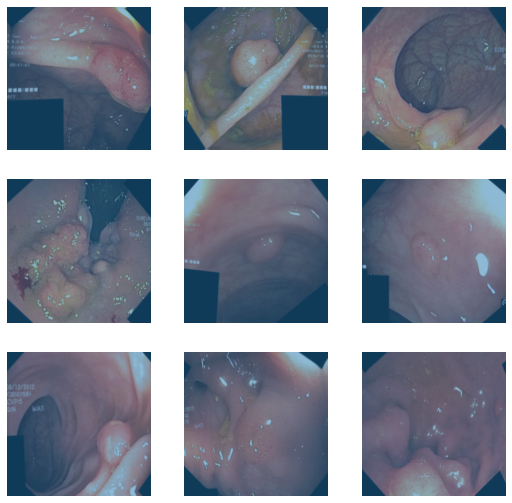

In [61]:
dlsMy.show_batch()

In [62]:
learnC = unet_learner(dlsMy, resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=Dice(axis=1))

SuggestedLRs(lr_min=0.00036307806149125097, lr_steep=5.248074739938602e-05)

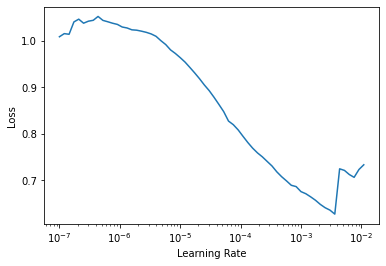

In [63]:
learnC.lr_find()

#### Image loaders from a directory

In [64]:
label_mask = 'bmasks1'
train = 'images'
codes=np.array(['Background','Polypblob'])
item_tfms  = [Resize(256, method=ResizeMethod.Squish)]  #### method='crop'
batch_tfms = [*aug_transforms(size=256), Normalize.from_stats(*imagenet_stats)]
path

Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG')

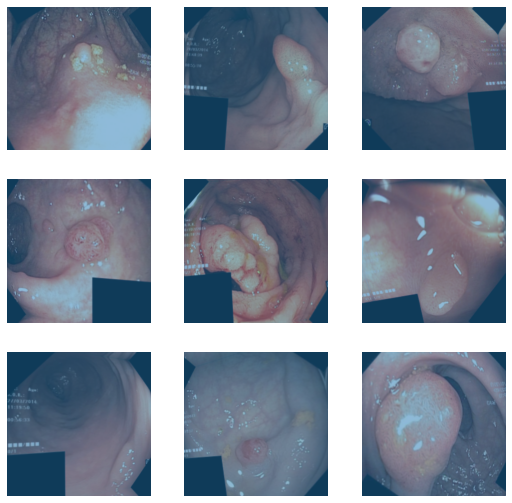

In [65]:
#dlsMy = customSegImgDataLoaders.from_folders(path, trainfold='images', label_mask='bmasks1', valid_pct=0.2, codes=codes, item_tfms=item_tfms, batch_tfms=batch_tfms, bs=10)
#dlsMy2=customSegImgDataLoaders.from_folders(path, trainfold=train, label_mask=label_mask, valid_pct=0.2, codes=codes, item_tfms=item_tfms, batch_tfms=batch_tfms, bs=10)
dlsMy2=ImageDataLoadersEx.from_folders(path, trainfold=train, label_mask=label_mask, valid_pct=0.2, codes=codes, item_tfms=item_tfms, batch_tfms=batch_tfms, bs=10)
dlsMy2.show_batch()
dlsMy2

In [66]:
learnC1 = unet_learner(dlsMy2, resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=Dice(axis=1))

(0.0006309573538601399, 3.0199516913853586e-05)

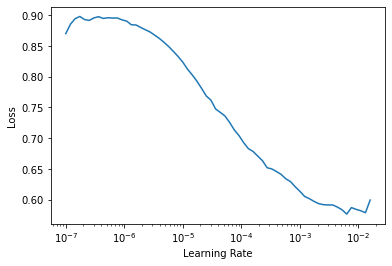

In [67]:
lr_min,lr_steep = learnC1.lr_find()
lr_min,lr_steep

In [68]:
# lr = 8e-04
# learnC1.fit_one_cycle(20, lr)
learnC1.fine_tune(20, freeze_epochs=3)

epoch,train_loss,valid_loss,dice,time
0,0.324072,0.275217,0.582657,00:24
1,0.280787,0.449018,0.399594,00:24
2,0.422744,0.345757,0.000000,00:24


epoch,train_loss,valid_loss,dice,time
0,0.184107,0.164830,0.795856,00:25
1,0.153461,0.150471,0.817293,00:25
2,0.128277,0.166467,0.764993,00:25
3,0.110061,0.155582,0.829312,00:25
4,0.110844,0.162462,0.819648,00:25
5,0.099522,0.137110,0.860010,00:25
6,0.081332,0.116595,0.876970,00:25
7,0.076742,0.123517,0.864200,00:25
8,0.068686,0.107493,0.874719,00:25
9,0.065421,0.116756,0.866748,00:25


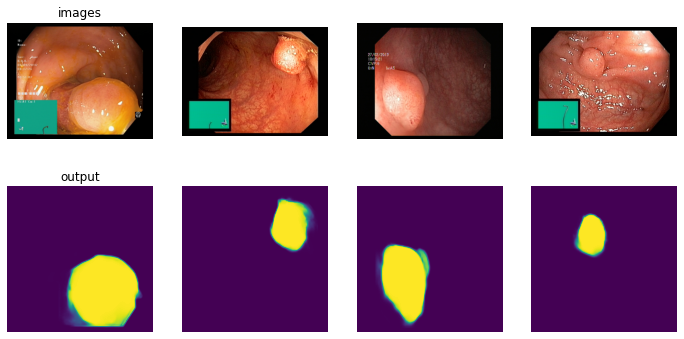

In [69]:
# fnames = get_image_files(path/'testimages')
# findx=20
# PILImage.create(fnames[findx]).show()
# im0=learnC1.predict(fnames[findx])[2][1,:].unsqueeze(0)
# show_image(im0, cmap='gray')
# #im0.shape

fnames = get_image_files(path/'testimages')
imgdicts={}
flist=[20, 40, 50, 60]
for i, img in enumerate(flist):
    imgdicts[0,i]=PILImage.create(fnames[img])
    imgdicts[1,i]=learnC1.predict(fnames[img])[2][1,:].unsqueeze(0)
show_images((imgdicts[0,0],imgdicts[0,1],imgdicts[0,2],imgdicts[0,3],imgdicts[1,0],imgdicts[1,1],imgdicts[1,2],imgdicts[1,3]), titles=('images','','','', 'output', '','','',), nrows=2, ncols=4)

#### Image loaders from a dictionary conataining images and their corresponding masks

In [70]:
path_img = path/'images'
path_lbl = path/'bmasks1'
dicLists=[{'image': image, 'label': label} for image, label in zip(sorted(get_image_files(path_img)), sorted(get_image_files(path_lbl)))]
dicLists[:5]

[{'image': Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/images/cju0qkwl35piu0993l0dewei2.jpg'),
  'label': Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks1/cju0qkwl35piu0993l0dewei2_b.png')},
 {'image': Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/images/cju0qoxqj9q6s0835b43399p4.jpg'),
  'label': Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks1/cju0qoxqj9q6s0835b43399p4_b.png')},
 {'image': Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/images/cju0qx73cjw570799j4n5cjze.jpg'),
  'label': Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks1/cju0qx73cjw570799j4n5cjze_b.png')},
 {'image': Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/images/cju0roawvklrq0799vmjorwfv.jpg'),
  'label': Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks1/cju0roawvklrq0799vmjorwfv_b.png')},
 {'image': Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/images/cju0rx1idathl0835detmsp84.jpg'),
  'label': Path('/home/saruarl

In [71]:
#### Dictionary image loaders

In [72]:
codes=np.array(['Background','Polypblob'])
item_tfms  = [Resize(256, method=ResizeMethod.Squish)]  #### method='crop'
batch_tfms = [*aug_transforms(size=256), Normalize.from_stats(*imagenet_stats)]

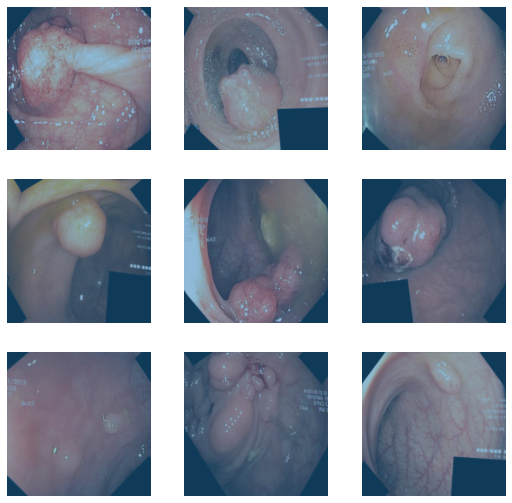

In [73]:
dlsMy3=ImageDataLoadersEx.from_dictionary_list(listdicts=dicLists, codes=codes, item_tfms=item_tfms, batch_tfms=batch_tfms, bs=10)
dlsMy3.show_batch()

(3.981071640737355e-05, 9.120108734350652e-05)

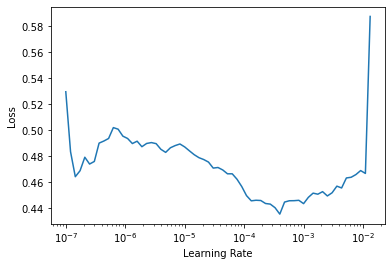

In [74]:
learn2 = unet_learner(dlsMy3, resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=Dice(axis=1))
lr_min,lr_steep = learn2.lr_find()
lr_min,lr_steep

In [77]:
#lr = 7e-04
#learn2.fit_one_cycle(20, lr)
learn2.fine_tune(20, freeze_epochs=3)

epoch,train_loss,valid_loss,dice,time
0,0.047261,0.142346,0.861823,00:18
1,0.098063,0.144488,0.843754,00:17
2,0.100379,0.113882,0.862425,00:18


epoch,train_loss,valid_loss,dice,time
0,0.072469,0.114951,0.862983,00:19
1,0.057777,0.135223,0.862385,00:19
2,0.067224,0.180380,0.799230,00:18
3,0.073635,0.118744,0.859366,00:19
4,0.072937,0.148017,0.849210,00:19
5,0.077976,0.111222,0.867816,00:19
6,0.065289,0.121625,0.873365,00:19
7,0.055567,0.155391,0.869920,00:19
8,0.058433,0.117832,0.864851,00:19
9,0.056947,0.169536,0.843345,00:19


In [76]:
# fnames = get_image_files(path/'testimages')
# findx=30
# PILImage.create(fnames[findx]).show()
# im0=learn2.predict(fnames[findx])[2][1,:].unsqueeze(0)
# show_image(im0, cmap='gray')
# #im0.shape

In [ ]:
####def label_func(x): return listdicts[0][lblkey].parent/f'{x.stem}_b{listdicts[0][lblkey].suffix}'

In [ ]:
####listdicts[0][lblkey].parent/f'{x.stem}_b{listdicts[0][lblkey].suffix}'

In [56]:
fnames = get_image_files(path/'testimages')
outTensor=learn.predict(fnames[20])[2][1,:].unsqueeze(0)
outMask=cast(outTensor,TensorMask)
type(outMask)

IndexError: too many indices for tensor of dimension 1

In [61]:
#to_image(outTensor)
learn.predict(fnames[20])[1]

tensor(119)

In [42]:
outTensor[2].shape

torch.Size([2, 256, 256])